<a href="https://colab.research.google.com/github/mgonzal1/nma_wombat_connectivy_project/blob/example/connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title imports and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sklearn.metrics
import ipywidgets as widgets 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [ ]:
#@title Representative session
#@markdown As first step, lets choose 1 session to start trainning the model. Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.
@widgets.interact
def get_representative_session(min_areas=(0,7)):
  """ To simplify the model we are selecting a session recording with most of the regions represented.
    This interactive function help us to decide the session based on the minimal regions represented and number of 
    total neurons recorded.

  """
  print("")
  brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                  ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                  ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                  ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                  ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                  ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                  ]
  regions = ["visual ctx", "thal", "hipp", "non-visual ctx", "midbrain", "basal ganglia", "cortical subplate"]
  for i in range (0,38):
    session = alldat[i]
    brain_areas = set(session['brain_area'])
    representative = []
    neurons_in_area = []
    for group in brain_groups:
        representative.append(any(area in brain_areas for area in group))
    
    if(representative.count(True)>min_areas):
      print("Session:" , i, "Total neurons:",session['brain_area'].shape[0])
      #labels, sizes = np.unique(session['brain_area'], return_counts=True)
      #print(sizes)
      #fig = plt.figure()
      #ax = fig.add_axes([0,0,1,1])
      #ax.bar(regions,representative)
      #ax.set_title("Session {}".format(i))
      #plt.show()


interactive(children=(IntSlider(value=3, description='min_areas', max=7), Output()), _dom_classes=('widget-int…

In [3]:
# SET DEFAULTS
trial_time = 2
session=12
n_sessions = len(alldat)

In [4]:
#@title General functions to get data
def filter_no_go_choice(data_set):
  """
  In order to reduce the complexity on the decode model(A3), we are removing the no-go trials 
  so we kept binary choice (left or right) that fits with a LogisticRegression model
   Args: 
      data_set: Subset of alldat

  Returns:
   new_data_set (dict): dat['spks']: neurons by trials.
                        dat['brain_area']: brain area for each neuron recorded.
                        dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
                        dat['contrast_left']: contrast level for left stimulus.
                        dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.
  """
  new_data_set =  {}
  index_trials = data_set['response'].nonzero()
  # Remove baseline(first 50 bins) and get FR per neuron
  new_data_set.update({"spks":(data_set["spks"][:,index_trials[0],50:].sum(axis=2)/trial_time).T})
  new_data_set.update({"brain_area":data_set["brain_area"]})
  new_data_set.update({"response": data_set["response"][index_trials]})
  new_data_set.update({"contrast_right": data_set["contrast_right"][index_trials]})
  new_data_set.update({"contrast_left": data_set["contrast_left"][index_trials]})
  return new_data_set

def get_spks_from_area(dat,brain_area):
  spks = dat["spks"].T
  n_neurons = spks.shape[0]
  index_neurons = np.zeros(n_neurons,dtype=bool)
  for neuron in range(n_neurons):
    index_neurons[neuron] = dat['brain_area'][neuron] in brain_area

  area_data = (spks[index_neurons,:].T)
  return area_data, index_neurons

def get_visual_ctx(data_set):
  visual_ctx = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
  visual_data, _ = get_spks_from_area(data_set, visual_ctx)
  return visual_data

def get_motor_ctx(data_set):
  motor_ctx = ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"]
  motor_data, _ = get_spks_from_area(data_set, motor_ctx)
  return motor_data

def get_stimulus(data_set):
  """
   Args: 
      data_set: (map) Subset of alldat
      
   Returns:
      stims[nTrials x 3]  bias: constant with ones
                          stim_left: contrast level for the right stimulus.
                          stim_right: contrast level for left stimulus.
  """


  stims = data_set['contrast_left'], data_set['contrast_right']
  stims = np.array(stims).T
  n_trials = stims.shape[0]
  stims = np.column_stack((np.ones(n_trials),stims))
  return stims

def get_response(data_set):
  """
   Args: 
      data_set: Subset of alldat

   Returns:
        np.array: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
  """
  response =  np.array(data_set['response'])
  return response

def get_binary_response(data_set):
  """
   To simplify the model we ares going to use a binary response instead of the 3 possible values: left, no-action, right
   to true or false comparing the stimulus to the expected actions. 

   Args: 
      data_set: Subset of alldat

   Returns:
        binary (np.array boolean) : Returns True or False
  """
  vis_left, vis_right = [data_set["stims"][:,1], data_set["stims"][:,2]]
  response = get_response(data_set)
  binary_response = np.sign(response)==np.sign(vis_left-vis_right)
  return binary_response

def split_validation_set(data_set):
  """
  Get a subset of alldat for validation purposes. This should be ~5%-10% of all the data.


  Returns:
   train_set (dict): dat['spks']: neurons by trials.
                     dat['brain_area']: brain area for each neuron recorded.
                     dat['stims']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
                     dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.
  """

  stims=get_stimulus(data_set)
  response = get_response(data_set)
  spk= data_set['spks']
  # # create training and testing vars
  stim_train, stim_test, spk_train, spk_test, response_train, response_test = train_test_split(stims, spk, response, test_size=0.1)
  train_set = {
      "spks": spk_train, 
      "stims": stim_train, 
      "response": response_train, 
      "brain_area":data_set['brain_area']
      }
  validation_set = {
      "spks": spk_test,
      "stims": stim_test, 
      "response": response_test, 
      "brain_area":data_set['brain_area']
      }
  return train_set, validation_set

In [5]:
# Get train and validation data
data_set = filter_no_go_choice(alldat[session])
data_set, val_set = split_validation_set(data_set)
#train_set (dict): dat['spks']: neurons by trials.
#                  dat['brain_area']: brain area for each neuron recorded.
#                  dat['stims']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
#                  dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.

# MODEL 1:  Encodig from visual stimulus

Using Multiple Linear Regresion:

\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_1 x_2 + ... +\theta_d x_d + \epsilon
\end{align}

where $\theta_0$ is the intercept and $d$ is the number of features.


Testing with k-fold cross-validation

**Parameters:**
*   Visual stimulus : [nTrials x 3] Contrast on left and right

\begin{align}
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2}  \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots  \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix}
\end{align}


*   Visual trials matrix : [nTrials x Neurons]

\begin{align}
\mathbf{Y} = 
\begin{bmatrix}
x_{1,1} & x_{1,2} & \dots & x_{1,m}  \\
x_{2,1} & x_{2,2}  & \dots & x_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
x_{n,1} & x_{n,2} & \dots  &  x_{n,m}
\end{bmatrix}
\end{align}



**Returns**
*  A1 matrix [2x ntrials]

\begin{align}
\mathbf{\hat \theta} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{2,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}
\end{bmatrix}
\end{align}



**Others**
*   Calculate MSE per Neuron

$$ MSE = \frac 1 N ||y - \hat y||^2 = \sum_{i=1}^N (y_i - \hat y_i)^2 $$


$$ nE = \frac \sqrt{MSE} \hat y $$

*   Calculate $R^2$ per Neuron


\begin{align}
R^2 = \frac{\sum_{i=1}^n(\hat y_i - \ \bar{y})^2}{\sum_{i=1}^n (y_i - \ \bar{y})^2}.
\end{align}


*   Test with more sessions, the MSE decrease?






In [6]:
visual_dat = get_visual_ctx(data_set)
stim = data_set["stims"]

model = LinearRegression(fit_intercept=False).fit(stim, visual_dat) 

A1 = model.coef_.T

visual_dat_hat = stim @ A1
mse = np.mean( (visual_dat-visual_dat_hat)**2 )

r2_metrics =  sklearn.metrics.r2_score(visual_dat,visual_dat_hat)

print(f'MSE {mse}')
print(f'R2 {r2_metrics}')




MSE 4.195156609355645
R2 0.07173314443977295


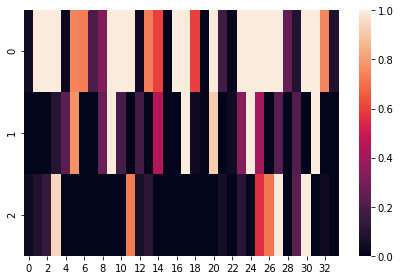

In [7]:
# dataset 
df = pd.DataFrame(A1)
# # Default heatmap: just a visualization of this square matrix

p1 = sns.heatmap(df, vmin=0, vmax=1)

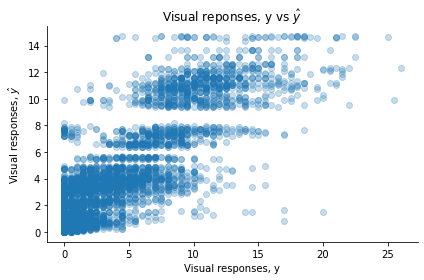

In [13]:
#plt.scatter(visual_dat.flatten(), visual_dat_hat.flatten(), alpha=0.3) 
plt.scatter(visual_dat,visual_dat_hat,alpha=0.25)
plt.title("Visual reponses, y vs $\hat y$ ")
plt.xlabel("Visual responses, y")
plt.ylabel("Visual responses, $\hat y$")
plt.show()

In [26]:
n_visual_dat = np.zeros(visual_dat.shape[1])
n_visual_dat_hat = np.zeros(visual_dat.shape[1])
n_mse = np.zeros(visual_dat.shape[1])
n_r2_metrics = np.zeros(visual_dat.shape[1])
n_mse_norm = np.zeros(visual_dat.shape[1])

for j in range(visual_dat.shape[1]):

  n_visual_dat =visual_dat[:,j]

  model_n = LinearRegression(fit_intercept=False).fit(stim, n_visual_dat)

  A1_n = model_n.coef_.T

  n_visual_dat_hat = stim @ A1_n
  n_visual_dat_norm= np.mean(n_visual_dat)
  
  n_mse [j]= np.mean( (n_visual_dat-n_visual_dat_hat)**2 )
  n_mse_norm [j]= np.sqrt(n_mse [j]) / n_visual_dat_norm
  
  n_r2_metrics [j] =  sklearn.metrics.r2_score(n_visual_dat,n_visual_dat_hat)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


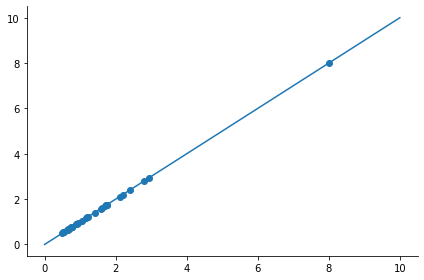

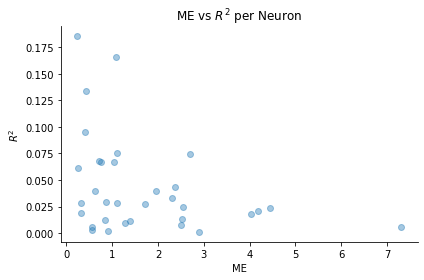

In [33]:
#plt.scatter(n_mse_norm.flatten(), n_r2_metrics.flatten())
#plt.scatter(n_mse.flatten(), n_r2_metrics.flatten())
plt.scatter(n_mse_norm,n_r2_metrics,alpha=0.4)
plt.title("ME vs $R^2$ per Neuron")
plt.xlabel("ME")
plt.ylabel("$R^2$")
plt.show()

In [31]:
n_mse<

array([2.74815735e-02, 4.56124150e+00, 1.02805838e+01, 3.89754277e+00,
       1.15343863e-01, 1.25239549e+00, 4.09796151e-01, 1.26706152e-01,
       5.10297782e-01, 8.18326211e+00, 1.77873134e+00, 4.56947323e+00,
       1.06547076e-01, 3.85900658e-01, 5.67056219e-01, 0.00000000e+00,
       5.00870322e+00, 7.22026022e+00, 5.70305708e-01, 4.45691442e-03,
       1.29400984e+01, 3.00544613e-01, 1.48781030e-02, 9.33643927e+00,
       2.47611580e+01, 1.81245750e+01, 6.93959651e+00, 7.95693011e+00,
       1.65466058e-01, 4.61694729e-01, 7.43750499e+00, 3.55673162e+00,
       1.03080368e+00, 3.28178857e-02])

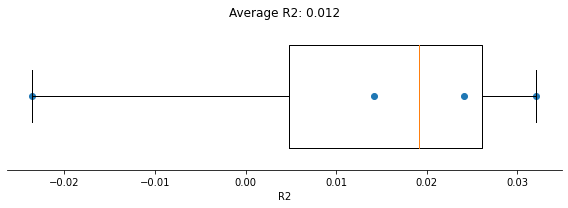

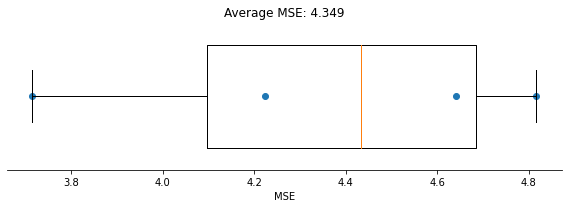

In [37]:
def cross_validation(stim_train, visual_train, n_splits):
  # Initialize the split method
  kfold_iterator = KFold(n_splits)
  mse_all =  []
  r2_all = []

  for i_split, (train_indices, test_indices) in enumerate(kfold_iterator.split(stim_train)):
      
      # Split up the overall training data into cross-validation training and validation sets
      stim_cv_train = stim_train[train_indices]
      visual_cv_train = visual_train[train_indices]

      #Let's ignore the test data in our model 
      stim_cv_test = stim_train[test_indices]
      visual_cv_test = visual_train[test_indices]

      # Train the model [MLR]
      modelA1 = LinearRegression(fit_intercept=False).fit(stim_cv_train, visual_cv_train) 
      theta_hats = modelA1.coef_.T

      # Test / Prediction
      visual_cv_test_hat =  stim_cv_test @ theta_hats

      # Compute MSE
      mse_this_split = np.mean((visual_cv_test-visual_cv_test_hat)**2 )
      mse_all.append(mse_this_split)

      #Compute R2
      r2_this_split = sklearn.metrics.r2_score(visual_cv_test,visual_cv_test_hat)
      r2_all.append(r2_this_split)

  return mse_all, r2_all

num_splits = 4
mse_all, r2_all = cross_validation(stim, visual_dat, num_splits)
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(r2_all, vert=False, widths=.7)
ax.scatter(r2_all, np.ones(num_splits))
ax.set(
  xlabel="R2",
  yticks=[],
  title=f"Average R2: {np.mean(r2_all):.3f}"
)
ax.spines["left"].set_visible(False)


f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(mse_all, vert=False, widths=.7)
ax.scatter(mse_all, np.ones(num_splits))
ax.set(
  xlabel="MSE",
  yticks=[],
  title=f"Average MSE: {np.mean(mse_all):.3f}"
)
ax.spines["left"].set_visible(False)
 

# MODEL2: Connectivity Model
Regularization with ridge penalty (L2).

$$-\log\mathcal{L}'(\theta | X, y)=
-\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i\theta_i^2,
$$

with a regularization strength of 20

**Parameters:**

* A1 `[3 x nNeurons_visual ]` :  Weight matrix of encoding model (visual stimulus to visual area)
* Motor matrix `[nTrials x nNeurons_motor]`: spikes rates of neurons involved in motor function.

**Returns**:
* A2 `[nNeurons_visual , nNeurons_motor]`: Weight  matrix of connectivity model (visual area to motor area)

In [67]:
#DRAFT : A2  model


#### Calculo del parametro alpha
#alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20,100,1000]
# parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
# ridge_regressor = GridSearchCV(modelo, parameters,scoring='neg_mean_squared_error', cv=5)
# ridge_regressor.fit(visual_dat, motor_dat) 
# ridge_regressor.best_params_
# ridge_regressor.best_score_

# obtenemos matriz de áreas motoras & definimos modelo
motor_dat = get_motor_ctx(data_set)
ridge = Ridge(alpha=1)

#Obtener thetas
ridge.fit(visual_dat_hat, motor_dat) 
A2 = ridge.coef_.T

# Obtener motor_dat_hat
#motor_dat_hat = visual_dat_hat @ A2
motor_dat_hat = ridge.predict(visual_dat_hat)

# MSE & R2
print("ridge MSE:", mean_squared_error(motor_dat, motor_dat_hat))
print("ridge score:",ridge.score(visual_dat_hat, motor_dat))
#r2_metrics =  sklearn.metrics.r2_score(motor_dat,motor_dat_hat)
#print(f'R2 {r2_metrics}')
#print("ridge coef:", ridge.coef_)



ridge MSE: 13.466220918518813
ridge score: 0.07710065949395793


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [48]:
np.corrcoef(motor_dat_hat.flatten(),motor_dat.flatten())**2

array([[1.        , 0.43642267],
       [0.43642267, 1.        ]])

In [59]:
u = np.sum((motor_dat_hat.flatten()-motor_dat.flatten())**2)
v = np.sum( (motor_dat-motor_dat.mean(axis=0)).flatten()**2 )
1-u/v

0.07704538105518433

In [58]:
ridge.score(visual_dat_hat,motor_dat)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.07704538105518417

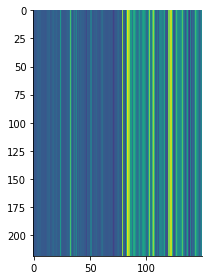

In [41]:
plt.imshow(ridge.predict(visual_dat_hat) - motor_dat_hat)

In [ ]:
# dataset 
df = pd.DataFrame(A2)
# # Default heatmap: just a visualization of this square matrix

p1 = sns.heatmap(df, vmin=0, vmax=1)

# MODEL3:  Decoding from motor
Logistic Regression no penalty
$$ \hat{y} \equiv p(y=1|x,\theta) = \sigma(\theta^Tx)$$
**Parameters:**
*   Motor matrix `[nTrials x nNeurons]`: spikes rates of neurons involved in motor function.
*   Reponses `[nTrials]`: 2 categories.  Task of turning a wheel to the left or to the rigth. *NoGo trials were ignored for simplicity*

**Returns**
* A3 `[nNeurons]`: Weight vector


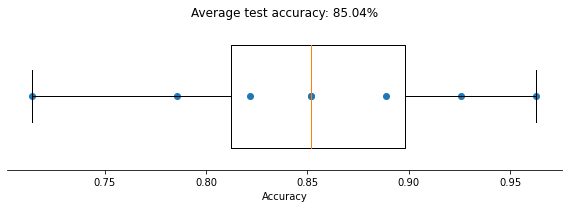

In [68]:
# obtenemos matrices 'y' y 'x'
motor_dat = get_motor_ctx(data_set)
binary_dat = data_set["response"]

#definimos el modelo & ajustamos los datos
log_reg = LogisticRegression(penalty="none")
log_reg.fit(motor_dat, binary_dat) 

# predicciones
binary_dat_hat = log_reg.predict(motor_dat)

#accuracy
similarity = (binary_dat == binary_dat_hat)   #nos da booleans de [true false] de predicciones correctas
accuracy = np.sum(similarity)/len(binary_dat)

#crossvalidation 
accuracies = cross_val_score(LogisticRegression(penalty='none'), motor_dat, binary_dat, cv=8)

# A3
A3 = log_reg.coef_.T

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

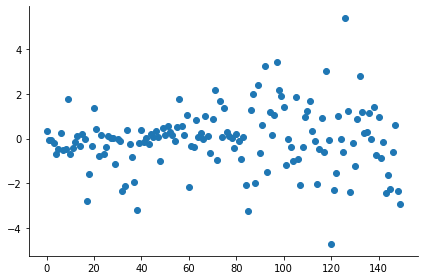

In [72]:
plt.scatter(range(len(A3)),A3)

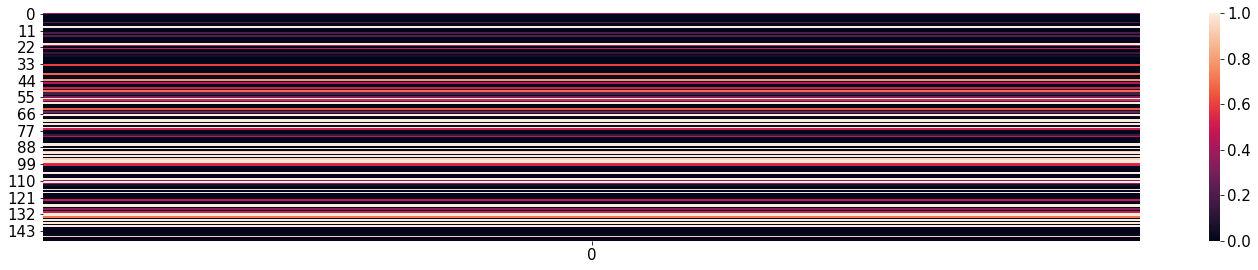

In [ ]:
# dataset 
df = pd.DataFrame(A3)
# # Default heatmap: just a visualization of this square matrix

p1 = sns.heatmap(df, vmin=0, vmax=1)

# Model
$$ \hat{choice} = stim A1 A2 A3 $$

**Parameters**
* stim `[nTrials x 3]` :  Visual stimulus, contrast on left and right
* A1 `[3 x nNeurons_visual]` : Weight matrix of encoding model (visual stimulus to visual area)
* A2 `[nNeurons_visual , nNeurons_motor]`: Weight  matrix of connectivity model (visual area to motor area)
* A3 `[nNeurons_motor]`: Weight vector of decoding model (motor area to task response)

In [74]:
response_hat =   stim @ A1 @ A2 @ A3
data_hat_set =  {
      "stims": stim, 
      "response": response_hat 
      }

In [88]:
((sigmoid(motor_dat_hat @ A3) > 0.5) == (binary_dat>0) ).mean()

0.498321552928421

In [ ]:
( ((stim @ A1)@A2) @A3)

In [83]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

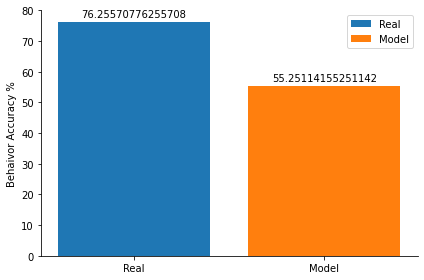

In [75]:
#@title Behavior Accuracy 

binary_resp_behav=get_binary_response(data_set)
acc_behav= 100*(np.sum(binary_resp_behav==True)/len(binary_resp_behav))


# Get behavior of the mode
data_set_hat =  {
      "stims": stim, 
      "response": response_hat 
      }

binary_resp_model=get_binary_response(data_set_hat)
acc_behav_model= 100*(np.sum(binary_dat_hat==True)/len(binary_dat_hat))


labels = ["Behavior", "Model"]
#x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar( "Real", acc_behav,  label='Real')

rects2 = ax.bar("Model" , acc_behav_model,  label='Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Behaivor Accuracy %')


ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()